In [541]:
import os, torch
os.chdir("/Users/ESKO/PYWORK/NHITS")
print(os.getcwd())

C:\Users\ESKO\PYWORK\NHITS


In [837]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from ray import tune
from sklearn.preprocessing import StandardScaler

from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoTFT
from neuralforecast.models import NBEATS, NBEATSx, NHITS, TFT, LSTM
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, GMM, PMM
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.losses.pytorch import MAE

## <기준날짜 및 예측 기간 설정>

In [1036]:
cutoff_date = '2022-07-30' ## len = 65
test_period = 5  ## 예측 기간 (월)
corr_rate = 0.7 ## Lag corr rate
hist_corr_rate = 0.9 ## Lag corr rate
future_variable_limit = 2
hist_variable_limit = 5

## <원 data set>

In [1037]:
df = pd.read_csv('./data/metal_pst.csv')
df.rename(columns={'date':'ds'},inplace=True)
df.rename(columns={'li2co3_cif_fast_kg_spot_exchng':'y'},inplace=True)
df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d')

df_tgt = df.iloc[:,3:]
scaler = StandardScaler()
scaler.fit(df_tgt)
arr = scaler.transform(df_tgt)
df_tmp = pd.DataFrame(arr, columns=df_tgt.columns)
df = pd.concat([df.iloc[:,:3],df_tmp], axis=1)

raw_y_set_resampled = df.copy()
raw_y_set_resampled.rename(columns={'ds':'date'},inplace=True)
raw_y_set_resampled.rename(columns={'lioh_cif_fast_kg_spot_exchng':'y2'},inplace=True)
del raw_y_set_resampled['unique_id']

## Feature shift

In [1038]:
%%time

raw_y_set_resampled = raw_y_set_resampled[raw_y_set_resampled.date<=cutoff_date]
raw_y_set_shifted_merged = raw_y_set_resampled['date']

for i in range(len(raw_y_set_resampled.columns)):
    if i == len(raw_y_set_resampled.columns) - 1:
        break
    raw_y_set_shifted = raw_y_set_resampled.iloc[:,[0,i+1]].dropna()
    for j in range(test_period-1,test_period):
        raw_y_set_shifted = pd.concat([raw_y_set_shifted, (raw_y_set_shifted.iloc[:,1].shift(j+1).rename(raw_y_set_resampled.columns[i+1] + '_' +str(j+1)+ '_'))],axis=1)
        raw_y_set_shifted_merged = pd.merge(raw_y_set_shifted_merged, raw_y_set_shifted, how= 'outer') 
        if j == len(raw_y_set_shifted.iloc[:,1]) -2 :
            break
# raw_y_set_shifted_merged.to_csv('./data/raw_y_set_shifted_merged.csv', encoding='cp949')

CPU times: total: 11.5 s
Wall time: 24.4 s


#### 해당 기간에서의 lag corr best

In [1039]:
raw_y_set_shifted_merged

,date,y,y_5_,y2,y2_5_,Baltic Dry Index (BDI),Baltic Dry Index (BDI)_5_,Howe Robinson Container Index,Howe Robinson Container Index_5_,Shanghai Containerized Freight Index (SCFI),...,Allkem Limited (AKE.AX)_price_Open,Allkem Limited (AKE.AX)_price_Open_5_,Allkem Limited (AKE.AX)_price_High,Allkem Limited (AKE.AX)_price_High_5_,Allkem Limited (AKE.AX)_price_Low,Allkem Limited (AKE.AX)_price_Low_5_,Allkem Limited (AKE.AX)_price_Close,Allkem Limited (AKE.AX)_price_Close_5_,Allkem Limited (AKE.AX)_price_Adj Close,Allkem Limited (AKE.AX)_price_Adj Close_5_
0,2016-01-31,20.177268,NaN,-0.237734,NaN,-1.302468,NaN,-0.644064,NaN,-0.195705,...,-0.915916,NaN,-0.911882,NaN,-0.921663,NaN,-0.909069,NaN,-0.909069,NaN
1,2016-02-29,23.306868,NaN,-0.054803,NaN,-1.396112,NaN,-0.645288,NaN,-0.182527,...,-0.910118,NaN,-0.915569,NaN,-0.908508,NaN,-0.916207,NaN,-0.916207,NaN
2,2016-03-31,25.223010,NaN,0.133909,NaN,-1.305967,NaN,-0.644523,NaN,-0.362815,...,-0.833402,NaN,-0.834459,NaN,-0.834589,NaN,-0.834453,NaN,-0.834453,NaN
3,2016-04-30,25.308243,NaN,0.173425,NaN,-1.041598,NaN,-0.648195,NaN,-0.472294,...,-0.691659,NaN,-0.695181,NaN,-0.693237,NaN,-0.700107,NaN,-0.700107,NaN
4,2016-05-31,24.875099,NaN,0.107095,NaN,-1.026945,NaN,-0.645747,NaN,-0.487834,...,-0.497700,NaN,-0.494779,NaN,-0.496022,NaN,-0.493870,NaN,-0.493870,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,2022-02-28,56.425000,19.083333,1.270279,-0.280700,0.406105,3.299182,2.294724,1.991462,1.435042,...,1.168835,1.124191,1.174279,1.123562,1.163390,1.129411,1.167415,1.129772,1.167415,1.129772
74,2022-03-31,71.086957,22.750000,2.126927,-0.096964,1.148209,3.926870,2.612162,1.998856,1.241856,...,1.471655,1.020054,1.468981,1.006143,1.476677,1.008416,1.477051,1.008169,1.477051,1.008169
75,2022-04-30,75.804348,28.170455,2.687810,0.164625,0.860751,1.521353,2.556884,1.794166,1.425830,...,2.259286,1.240984,2.271036,1.248657,2.255625,1.253894,2.261700,1.257281,2.261700,1.257281
76,2022-05-31,74.295455,33.043478,2.621695,0.286579,1.713126,1.582281,2.501607,1.839908,1.892086,...,2.106495,1.185124,2.106820,1.187299,2.111163,1.189690,2.116623,1.197156,2.116623,1.197156


In [1040]:
raw_y_set_shifted_merged_corr = raw_y_set_shifted_merged.corr()
raw_y_set_shifted_merged_filtered = raw_y_set_shifted_merged_corr[raw_y_set_resampled.columns.drop('date')]
# raw_y_set_shifted_merged_filtered = raw_y_set_shifted_merged_filtered.loc[raw_y_set_shifted_merged_filtered.index != 'y']
# raw_y_set_shifted_merged_filtered = raw_y_set_shifted_merged_filtered.loc[raw_y_set_shifted_merged_filtered.index != 'y2']
raw_y_set_shifted_merged_filtered_y = raw_y_set_shifted_merged_filtered.iloc[:,:1]
raw_y_set_shifted_merged_filtered_upto_corr_rate = raw_y_set_shifted_merged_filtered_y[raw_y_set_shifted_merged_filtered_y.y >= corr_rate]
raw_y_set_shifted_merged_filtered_upto_corr_rate = raw_y_set_shifted_merged_filtered_upto_corr_rate.sort_values('y',ascending=False)
raw_y_set_shifted_merged_filtered_upto_corr_rate = raw_y_set_shifted_merged_filtered_upto_corr_rate[raw_y_set_shifted_merged_filtered_upto_corr_rate.index.str.contains(f'_{test_period}_')]
raw_y_set_shifted_merged_filtered_upto_corr_rate = raw_y_set_shifted_merged_filtered_upto_corr_rate[:future_variable_limit]

futr_list = raw_y_set_shifted_merged_filtered_upto_corr_rate.index.values.tolist()
futr_list = [word.replace(f"_{test_period}_", "") for word in futr_list]

# if 'li2co395_am_kg' in futr_list:
#     futr_list = [w.replace('li2co395_am_kg', 'li2co3_995_am_kg') for w in futr_list]
# raw_y_set_shifted_merged_filtered_upto_corr_rate = raw_y_set_shifted_merged_filtered_upto_corr_rate.sort_values('y',ascending=False)

# if 'y2' in futr_list:
#     (futr_list).remove('y2')
# if 'li2co395_am_kg' in futr_list:
#     (futr_list).remove('li2co395_am_kg')
# if 'li2co3_995_am_kg' in futr_list:
#     (futr_list).remove('li2co3_995_am_kg')
# if 'mn_mb_kg' in futr_list:
#     (futr_list).remove('mn_mb_kg')
# if 'al_lme_kg' in futr_list:
#     (futr_list).remove('al_lme_kg')

In [1041]:
raw_y_set_shifted_merged_filtered_upto_corr_rate

,y
mn_mb_kg_5_,0.961879
소맥 Durum [미국(생산자 가격)] 현물_5_,0.961142


In [1042]:
futr_list

['mn_mb_kg', '소맥 Durum [미국(생산자 가격)] 현물']

#### 해당 기간에서의 corr best

In [1043]:
hist_variable_limit

5

In [1044]:
hist_var_chcek = raw_y_set_resampled.iloc[:,1:]

hist_var_corr = hist_var_chcek.corr()
hist_var_corr_filtered = hist_var_corr.loc[hist_var_corr.index != 'y']
hist_var_corr_filtered = hist_var_corr_filtered.loc[hist_var_corr_filtered.index != 'y2']
hist_var_corr_filtered_y = hist_var_corr_filtered.iloc[:,:1]
hist_var_corr_filtered_y_corr_rate = hist_var_corr_filtered_y[hist_var_corr_filtered_y.y >= hist_corr_rate]
hist_var_corr_filtered_y_only = hist_var_corr_filtered_y_corr_rate[hist_var_corr_filtered_y_corr_rate.index.str.contains('li2co3')==False]
hist_var_corr_filtered_y_only = hist_var_corr_filtered_y_only[hist_var_corr_filtered_y_only.index.str.contains('lioh')==False]
hist_var_corr_filtered_y_only = hist_var_corr_filtered_y_only.sort_values('y',ascending=False)
hist_var_list = hist_var_corr_filtered_y_only.index.values.tolist()

hist_list = hist_var_list[:hist_variable_limit]
hist_list

['CPI_PRT_TOT_FOODENRG_AGRWTH',
 '대두 [미국(생산자 가격)] 현물',
 'CPI_BEL_TOT_AGRWTH',
 'CPI_PRT_TOT_AGRWTH',
 '중국 니켈 SEMIS 수입량']

In [1045]:
hist_var_corr_filtered_y_only

,y
CPI_PRT_TOT_FOODENRG_AGRWTH,0.947163
대두 [미국(생산자 가격)] 현물,0.946299
CPI_BEL_TOT_AGRWTH,0.938752
CPI_PRT_TOT_AGRWTH,0.934432
중국 니켈 SEMIS 수입량,0.903346
CPI_GBR_TOT_FOODENRG_AGRWTH,0.902181
CPI_LTU_TOT_AGRWTH,0.901834
CPI_GRC_TOT_AGRWTH,0.900623


#### static DF

In [1046]:
static_df = pd.read_csv('/users/ESKO/PYWORK/NHITS/data/static_df.csv')

## <Training & Test>

#### 날짜 확인

In [1047]:
# train = df.loc[df.ds < '2021-06-30']
# test = df.loc[df.ds > '2021-06-30']

#### 날짜 별 len 확인

In [1048]:
# len(df.loc[df.ds<'2021-06-30'])

In [1049]:
# len(Y_train_df)
# len(Y_test_df)
# len(df)

Test 용 DF 및 선행 변수 반영

In [1050]:
Y_train_df = df[df.ds<=cutoff_date]
Y_test_df = df[df.ds>cutoff_date]

if len(Y_test_df) > 12:    
    Y_test_df = Y_test_df[:12]
else:
    pass
# Y_train_df = df[df.ds<df['ds'].values[len(df.loc[df.ds<=cutoff_date])]]
# Y_test_df = df[df.ds>=df['ds'].values[len(df.loc[df.ds<=cutoff_date])]]

In [1051]:
futr_list

['mn_mb_kg', '소맥 Durum [미국(생산자 가격)] 현물']

In [1052]:
Y_test_df

,ds,unique_id,y,lioh_cif_fast_kg_spot_exchng,Baltic Dry Index (BDI),Howe Robinson Container Index,Shanghai Containerized Freight Index (SCFI),옥수수 For Grain [미국(생산자 가격)] 현물,원당 (daily) [ISA] 현물,대두 [미국(생산자 가격)] 현물,...,Pilbara Mineral Limited_price_Open,Pilbara Mineral Limited_price_High,Pilbara Mineral Limited_price_Low,Pilbara Mineral Limited_price_Close,Pilbara Mineral Limited_price_Adj Close,Allkem Limited (AKE.AX)_price_Open,Allkem Limited (AKE.AX)_price_High,Allkem Limited (AKE.AX)_price_Low,Allkem Limited (AKE.AX)_price_Close,Allkem Limited (AKE.AX)_price_Adj Close
78,2022-07-31,A,73.000000,2.389233,0.691597,2.439292,2.526593,2.377100,0.921668,2.852368,...,1.464141,1.460176,1.481963,1.473009,2.410643,1.436494,1.434052,1.439497,1.441548,1.441548
79,2022-08-31,A,73.000000,2.420773,-0.092744,2.119559,2.773368,2.369193,0.793818,2.593314,...,2.219001,2.233095,2.245839,2.264053,2.410643,2.144853,2.155770,2.181382,2.184215,2.184215
80,2022-09-30,A,74.047619,2.507937,-0.004062,1.188816,3.024986,2.250597,0.750690,1.621862,...,2.107414,2.092161,2.084336,2.084871,1.970948,2.828439,2.823884,2.834908,2.836251,2.836251
81,2022-10-31,A,77.673913,2.664680,0.381286,0.204375,3.036207,1.784119,0.691518,1.427572,...,2.352264,2.359441,2.354164,2.362142,2.222022,2.765597,2.782167,2.764528,2.761120,2.761120
82,2022-11-30,A,80.818182,2.828879,-0.226024,-0.008117,3.004479,1.784119,1.005474,1.621862,...,2.433279,2.443712,2.455263,2.452607,2.303940,2.830058,2.817705,2.816214,2.795982,2.795982
83,2022-12-31,A,80.882353,2.867154,-0.043847,-0.041773,3.301048,1.784119,1.131385,1.816153,...,1.980999,1.967237,1.981728,1.959693,1.857597,2.230517,2.206089,2.211335,2.207568,2.207568


In [850]:
futr_list = [
             'Baltic Dry Index (BDI)',
             # 'LGES 리튬소요량_수산화리튬(kg)',
             # '미국 비농업부분고용',
             'Howe Robinson Container Index',
             # 'Pilbara Mineral Limited price Open',
             # 'lioh_mag_am_kg',
             # 'Shanghai Containerized Freight Index (SCFI)',
             # 'li2co3_cif_fast_kg_spot_exchng'
            ]

In [1053]:
future_date_series = pd.date_range(pd.date_range(cutoff_date,periods=2,freq='M')[1],periods=test_period,freq='M')
future_date = pd.DataFrame(future_date_series,columns=['ds'])
# future_date['unique_id'] = 'A'
future_df_temp = pd.concat([raw_y_set_resampled.rename(columns={'date':'ds'}).iloc[-(test_period+len(Y_test_df)):,:],future_date])
future_df_temp[futr_list] = future_df_temp[futr_list].shift(test_period)

future_df_with_index = list(['ds','unique_id']) + futr_list
future_df_with_index

future_df_temp = future_df_temp[future_df_temp.columns[future_df_temp.columns.isin(future_df_with_index)]].reset_index(drop=True)
future_df_temp.insert(1, 'unique_id', 'A')
futr_df = future_df_temp.iloc[-test_period:,:].reset_index(drop=True)
futr_df

,ds,unique_id,소맥 Durum [미국(생산자 가격)] 현물,mn_mb_kg
0,2022-08-31,A,2.885040,2.900262
1,2022-09-30,A,2.686761,1.549461
2,2022-10-31,A,2.752854,0.363279
3,2022-11-30,A,2.356296,0.161546
4,2022-12-31,A,1.596226,0.058028


#### No 변수

In [1054]:
# horizon = len(Y_test_df)

# models = [
#           # NBEATS(input_size=5 * horizon, gpus = 1, h=horizon, max_epochs=100),
#           # NBEATSx(h=12, input_size=24,
#           #       # loss=DistributionLoss(distribution='Normal', level=[80, 90]),
#           #       gpus=1,
#           #       scaler_type='robust',
#           #       stat_exog_list = None,  
#           #       futr_exog_list = futr_list,
#           #       max_steps=100,
#           #       # val_check_steps=10,
#           #       # early_stop_patience_steps=2
#           #      ),
#           NHITS(input_size=5 * horizon, 
#                 h=horizon+1,
#                 gpus = 1,
#                 stat_exog_list = None,
#                 hist_exog_list=None,
#                 futr_exog_list = None,
#                 # futr_exog_list = futr_list,
#                 # n_freq_downsample=[24, 12, 1],
#                 # mlp_units = [[512, 512], [512, 512], [512, 512]],
#                 # n_pool_kernel_size = [2, 2, 1],
#                 # n_freq_downsample=[24, 12, 1],
#                 scaler_type = 'standard',
#                 learning_rate=1e-4,
#                 pooling_mode = 'MaxPool1d',
#                 activation='ReLU',
#                 batch_size=128,
#                 random_seed=42,
#                 max_epochs=200
#                ),
#            # NHITS(
#            #       h,
#            #       input_size,
#            #       futr_exog_list=None,
#            #       hist_exog_list=None,
#            #       stat_exog_list=None,
#            #       stack_types: list = ['identity', 'identity', 'identity'],
#            #       n_blocks: list = [1, 1, 1],
#            #       mlp_units: list = [[512, 512], [512, 512], [512, 512]],
#            #       n_pool_kernel_size: list = [2, 2, 1],
#            #       n_freq_downsample: list = [4, 2, 1],
#            #       pooling_mode: str = 'MaxPool1d',
#            #       interpolation_mode: str = 'linear',
#            #       dropout_prob_theta=0.0,
#            #       activation='ReLU',
#            #       loss=MAE(),
#            #       learning_rate=0.001,
#            #       batch_size=32,
#            #       windows_batch_size: int = 1024,
#            #       step_size: int = 1,
#            #       scaler_type='identity',
#            #       random_seed=1,
#            #       num_workers_loader=0,
#            #       drop_last_loader=False,
#            #       **trainer_kwargs,
    
#           # TFT(h=12, 
#           #     input_size=5 * horizon,
#           #     # hidden_size=20,
#           #     #loss=DistributionLoss(distribution='Poisson', level=[80, 90]),
#           #     #loss=DistributionLoss(distribution='Normal', level=[80, 90]),
#           #     #loss=DistributionLoss(distribution='StudentT', level=[80, 90]),
#           #     learning_rate=0.005,
#           #     stat_exog_list = None,
#           #     futr_exog_list = futr_list,
#           #     max_steps=100,
#           #     gpus=1,
#           #     # val_check_steps=10,
#           #     # early_stop_patience_steps=10,
#           #     scaler_type='robust',
#           #     # windows_batch_size=None,
#           #     enable_progress_bar=True),
#              ]
# nforecast_nv = NeuralForecast(models=models, freq='M')
# nforecast_nv.fit(df=Y_train_df)
# Y_hat_df_nv = nforecast_nv.predict(futr_df=futr_df).reset_index()

In [1055]:
# # Plot predictions
# fig, ax = plt.subplots(1, 1, figsize = (20, 7))
# Y_hat_df_nv = Y_test_df.merge(Y_hat_df_nv, how='left', on=['unique_id', 'ds'])
# plot_df_nv = pd.concat([Y_train_df, Y_hat_df_nv]).set_index('ds')

# plot_df_nv[['y', 'NHITS']].plot(ax=ax, linewidth=2, marker='o')
# plt.axvline(cutoff_date, color='red')

# ax.set_title(f'LI2CO3 Actual and Predicted Plot - Cutoff: {cutoff_date}', fontsize=22)
# ax.set_ylabel('LI2CO3_PRICE', fontsize=20)
# ax.set_xlabel('Date', fontsize=20)
# ax.legend(prop={'size': 15})
# ax.grid()

# fig.savefig(f'./data/forecast_plot_{cutoff_date}_nv.png')

In [1056]:
# plot_df_nv[['y', 'NHITS']].to_csv(f'./data/forecasting_{cutoff_date}_nv.csv',index=False)

#### Yes 변수

In [1057]:
futr_df

,ds,unique_id,소맥 Durum [미국(생산자 가격)] 현물,mn_mb_kg
0,2022-08-31,A,2.885040,2.900262
1,2022-09-30,A,2.686761,1.549461
2,2022-10-31,A,2.752854,0.363279
3,2022-11-30,A,2.356296,0.161546
4,2022-12-31,A,1.596226,0.058028


In [1058]:
if len(Y_test_df) > 0:
    horizon = len(Y_test_df)
else:
    horizon = len(futr_df)
    
    
if cutoff_date <= '2021-12-31':
    flexible = None
else:
    flexible = futr_list

models = [
          # NBEATS(input_size=5 * horizon, gpus = 1, h=horizon, max_epochs=100),
          # NBEATSx(h=horizon, input_size=5 * horizon,
          #       # loss=DistributionLoss(distribution='Normal', level=[80, 90]),
          #       gpus=1,
          #       scaler_type='robust',
          #       stat_exog_list = None,
          #       # hist_exog_list = hist_list,
          #       # futr_exog_list = None,  
          #       futr_exog_list = flexible,
          #       learning_rate=1e-4,
          #       mlp_units = [[512, 512], [512, 512], [512, 512]],
          #       batch_size=128,
          #       random_seed=42,
          #       n_blocks=[1, 1, 1],
          #       # val_check_steps=10,
          #       # early_stop_patience_steps=2
          #       max_steps=30
          #      ),
          NHITS(input_size=5 * horizon, 
                h=horizon,
                gpus = 1,
                stat_exog_list = None,
                # hist_exog_list = hist_list,
                futr_exog_list = flexible,
                # futr_exog_list = None,
                # futr_exog_list = futr_list,
                # n_blocks = [1, 1, 1],
                mlp_units = [[512, 512], [512, 512], [512, 512]],
                n_pool_kernel_size = [2, 2, 1],
                # n_freq_downsample=[24, 12, 1],
                scaler_type = 'robust',
                learning_rate=1e-4,
                pooling_mode = 'MaxPool1d',
                activation='ReLU',
                batch_size=128,
                random_seed=42,
                max_epochs=10
               ),
          # LSTM(h=horizon, input_size=5 * horizon,
          #        # loss=DistributionLoss(distribution='Normal', level=[80, 90]),
          #        scaler_type='standard',
          #        learning_rate=1e-4,
          #        encoder_n_layers=2,
          #        encoder_hidden_size=128,
          #        context_size=10,
          #        decoder_hidden_size=128,
          #        decoder_layers=2,
          #        gpus = 1,
          #        futr_exog_list=flexible,
          #        hist_exog_list=None,
          #        stat_exog_list=None,
          #        max_steps=200
          #        ),
           # NHITS(
           #       h,
           #       input_size,
           #       futr_exog_list=None,
           #       hist_exog_list=None,
           #       stat_exog_list=None,
           #       stack_types: list = ['identity', 'identity', 'identity'],
           #       n_blocks: list = [1, 1, 1],
           #       mlp_units: list = [[512, 512], [512, 512], [512, 512]],
           #       n_pool_kernel_size: list = [2, 2, 1],
           #       n_freq_downsample: list = [4, 2, 1],
           #       pooling_mode: str = 'MaxPool1d',
           #       interpolation_mode: str = 'linear',
           #       dropout_prob_theta=0.0,
           #       activation='ReLU',
           #       loss=MAE(),
           #       learning_rate=0.001,
           #       batch_size=32,
           #       windows_batch_size: int = 1024,
           #       step_size: int = 1,
           #       scaler_type='identity',
           #       random_seed=1,
           #       num_workers_loader=0,
           #       drop_last_loader=False,
           #       **trainer_kwargs,
    
          # TFT(h=horizon, 
          #     input_size=5 * horizon,
          #     #loss=DistributionLoss(distribution='Poisson', level=[80, 90]),
          #     #loss=DistributionLoss(distribution='Normal', level=[80, 90]),
          #     #loss=DistributionLoss(distribution='StudentT', level=[80, 90]),
          #     hidden_size=128,
          #     # n_head=4, 
          #     attn_dropout=0.2,
          #     # hist_exog_list=hist_list,
          #     dropout=0.6,
          #     learning_rate=1e-4,
          #     stat_exog_list = None,
          #     futr_exog_list = flexible,
          #     gpus=1,
          #     # val_check_steps=10,
          #     # early_stop_patience_steps=10,
          #     scaler_type='robust',
          #     # windows_batch_size=None,
          #     # enable_progress_bar=True,
          #     max_steps=200
          #    ),
             ]
nforecast = NeuralForecast(models=models, freq='M')
nforecast.fit(df=Y_train_df)
Y_hat_df = nforecast.predict(futr_df=futr_df, static_df=static_df).reset_index()

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

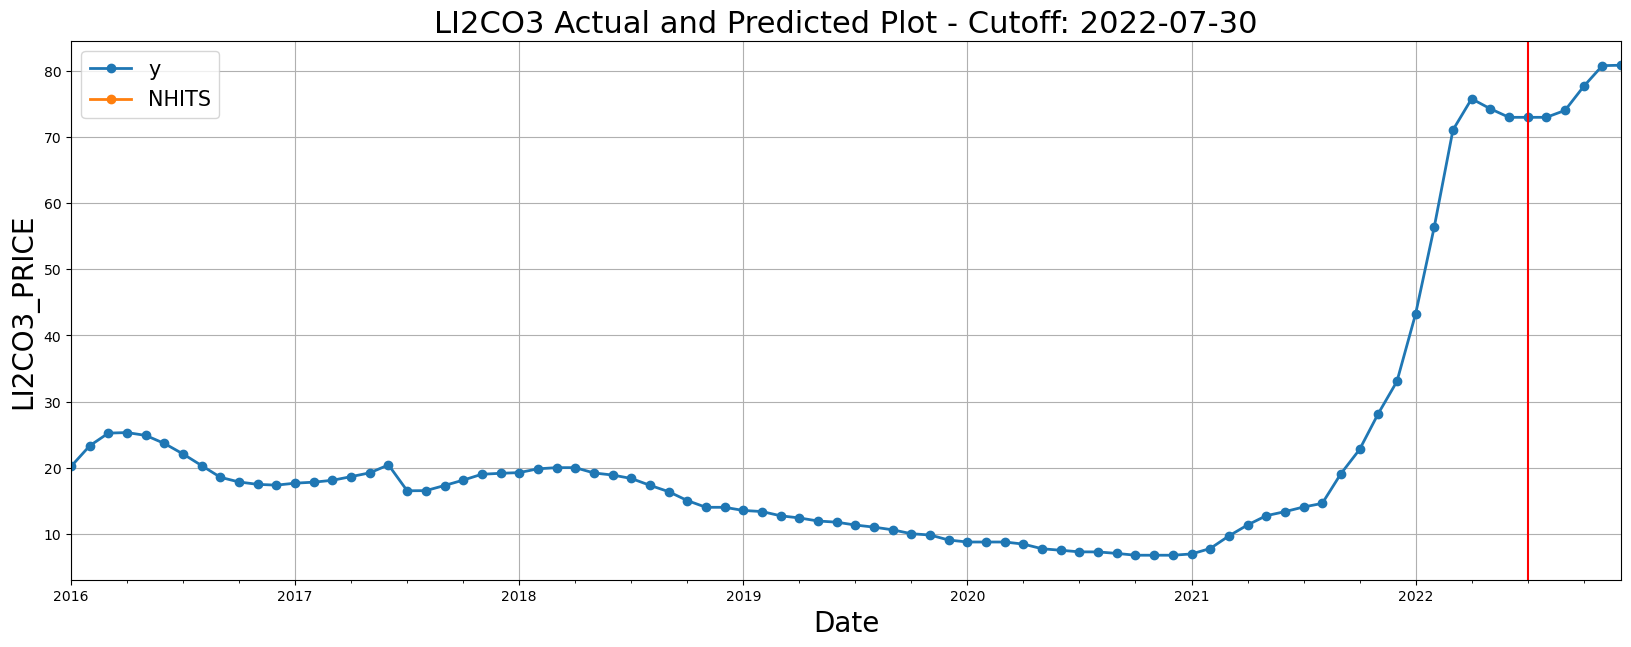

In [1059]:
# Plot predictions
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
Y_hat_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])
plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')

plot_df[['y','NHITS']].plot(ax=ax, linewidth=2, marker='o')

plt.axvline(cutoff_date, color='red')
ax.set_title(f'LI2CO3 Actual and Predicted Plot - Cutoff: {cutoff_date}', fontsize=22)
ax.set_ylabel('LI2CO3_PRICE', fontsize=20)
ax.set_xlabel('Date', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

# fig1.savefig(f'./data/forecasting_{cutoff_date}.png', dpi=100)
fig.savefig(f'./data/forecast_plot_{cutoff_date}_wv.png')

In [1060]:
plot_df[['y', 'NHITS']].to_csv(f'./data/forecast_plot_{cutoff_date}_wv.csv',index=False)

In [1061]:
Y_train_df

,ds,unique_id,y,lioh_cif_fast_kg_spot_exchng,Baltic Dry Index (BDI),Howe Robinson Container Index,Shanghai Containerized Freight Index (SCFI),옥수수 For Grain [미국(생산자 가격)] 현물,원당 (daily) [ISA] 현물,대두 [미국(생산자 가격)] 현물,...,Pilbara Mineral Limited_price_Open,Pilbara Mineral Limited_price_High,Pilbara Mineral Limited_price_Low,Pilbara Mineral Limited_price_Close,Pilbara Mineral Limited_price_Adj Close,Allkem Limited (AKE.AX)_price_Open,Allkem Limited (AKE.AX)_price_High,Allkem Limited (AKE.AX)_price_Low,Allkem Limited (AKE.AX)_price_Close,Allkem Limited (AKE.AX)_price_Adj Close
0,2016-01-31,A,20.177268,-0.237734,-1.302468,-0.644064,-0.195705,-0.461301,-0.468886,0.391356,...,-0.831670,-0.828692,-0.830830,-0.827825,-0.397665,-0.915916,-0.911882,-0.921663,-0.909069,-0.909069
1,2016-02-29,A,23.306868,-0.054803,-1.396112,-0.645288,-0.182527,-0.532459,-0.733272,0.138779,...,-0.748690,-0.746808,-0.752678,-0.750469,-0.397665,-0.910118,-0.915569,-0.908508,-0.916207,-0.916207
2,2016-03-31,A,25.223010,0.133909,-1.305967,-0.644523,-0.362815,-0.532459,-0.012903,0.099921,...,-0.731866,-0.730402,-0.733675,-0.731680,-0.397665,-0.833402,-0.834459,-0.834589,-0.834453,-0.834453
3,2016-04-30,A,25.308243,0.173425,-1.041598,-0.648195,-0.472294,-0.524553,-0.083130,-0.003701,...,-0.520540,-0.501075,-0.525438,-0.509230,-0.397665,-0.691659,-0.695181,-0.693237,-0.700107,-0.700107
4,2016-05-31,A,24.875099,0.107095,-1.026945,-0.645747,-0.487834,-0.445488,0.514051,-0.074941,...,-0.375846,-0.367456,-0.391346,-0.377609,-0.397665,-0.497700,-0.494779,-0.496022,-0.493870,-0.493870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,2022-02-28,A,56.425000,1.270279,0.406105,2.294724,1.435042,1.467862,0.798730,1.945680,...,2.197789,2.207543,2.190755,2.181831,2.058747,1.168835,1.174279,1.163390,1.167415,1.167415
74,2022-03-31,A,71.086957,2.126927,1.148209,2.612162,1.241856,1.831557,1.195636,2.269497,...,2.026895,2.013125,2.037362,2.013198,1.906047,1.471655,1.468981,1.476677,1.477051,1.477051
75,2022-04-30,A,75.804348,2.687810,0.860751,2.556884,1.425830,2.242691,1.391677,2.722841,...,2.170896,2.152358,2.152352,2.132638,2.410643,2.259286,2.271036,2.255625,2.261700,2.261700
76,2022-05-31,A,74.295455,2.621695,1.713126,2.501607,1.892086,2.385006,1.329234,3.305713,...,1.814178,1.807191,1.810962,1.808275,2.410643,2.106495,2.106820,2.111163,2.116623,2.116623


In [1062]:
plot_df

,unique_id,y,lioh_cif_fast_kg_spot_exchng,Baltic Dry Index (BDI),Howe Robinson Container Index,Shanghai Containerized Freight Index (SCFI),옥수수 For Grain [미국(생산자 가격)] 현물,원당 (daily) [ISA] 현물,대두 [미국(생산자 가격)] 현물,대두박 [파라나구아(FOB)] 현물,...,Pilbara Mineral Limited_price_High,Pilbara Mineral Limited_price_Low,Pilbara Mineral Limited_price_Close,Pilbara Mineral Limited_price_Adj Close,Allkem Limited (AKE.AX)_price_Open,Allkem Limited (AKE.AX)_price_High,Allkem Limited (AKE.AX)_price_Low,Allkem Limited (AKE.AX)_price_Close,Allkem Limited (AKE.AX)_price_Adj Close,NHITS
ds,,,,,,,,,,,,,,,,,,,,,
2016-01-31,A,20.177268,-0.237734,-1.302468,-0.644064,-0.195705,-0.461301,-0.468886,0.391356,-1.226492,...,-0.828692,-0.830830,-0.827825,-0.397665,-0.915916,-0.911882,-0.921663,-0.909069,-0.909069,NaN
2016-02-29,A,23.306868,-0.054803,-1.396112,-0.645288,-0.182527,-0.532459,-0.733272,0.138779,-1.332251,...,-0.746808,-0.752678,-0.750469,-0.397665,-0.910118,-0.915569,-0.908508,-0.916207,-0.916207,NaN
2016-03-31,A,25.223010,0.133909,-1.305967,-0.644523,-0.362815,-0.532459,-0.012903,0.099921,-1.436497,...,-0.730402,-0.733675,-0.731680,-0.397665,-0.833402,-0.834459,-0.834589,-0.834453,-0.834453,NaN
2016-04-30,A,25.308243,0.173425,-1.041598,-0.648195,-0.472294,-0.524553,-0.083130,-0.003701,-1.168180,...,-0.501075,-0.525438,-0.509230,-0.397665,-0.691659,-0.695181,-0.693237,-0.700107,-0.700107,NaN
2016-05-31,A,24.875099,0.107095,-1.026945,-0.645747,-0.487834,-0.445488,0.514051,-0.074941,0.104912,...,-0.367456,-0.391346,-0.377609,-0.397665,-0.497700,-0.494779,-0.496022,-0.493870,-0.493870,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31,A,73.000000,2.420773,-0.092744,2.119559,2.773368,2.369193,0.793818,2.593314,1.844361,...,2.233095,2.245839,2.264053,2.410643,2.144853,2.155770,2.181382,2.184215,2.184215,NaN
2022-09-30,A,74.047619,2.507937,-0.004062,1.188816,3.024986,2.250597,0.750690,1.621862,1.935267,...,2.092161,2.084336,2.084871,1.970948,2.828439,2.823884,2.834908,2.836251,2.836251,NaN
2022-10-31,A,77.673913,2.664680,0.381286,0.204375,3.036207,1.784119,0.691518,1.427572,1.447594,...,2.359441,2.354164,2.362142,2.222022,2.765597,2.782167,2.764528,2.761120,2.761120,NaN


In [1063]:
futr_df

,ds,unique_id,소맥 Durum [미국(생산자 가격)] 현물,mn_mb_kg,y,lioh_cif_fast_kg_spot_exchng,Baltic Dry Index (BDI),Howe Robinson Container Index,Shanghai Containerized Freight Index (SCFI),옥수수 For Grain [미국(생산자 가격)] 현물,...,Pilbara Mineral Limited_price_Open,Pilbara Mineral Limited_price_High,Pilbara Mineral Limited_price_Low,Pilbara Mineral Limited_price_Close,Pilbara Mineral Limited_price_Adj Close,Allkem Limited (AKE.AX)_price_Open,Allkem Limited (AKE.AX)_price_High,Allkem Limited (AKE.AX)_price_Low,Allkem Limited (AKE.AX)_price_Close,Allkem Limited (AKE.AX)_price_Adj Close
0,2022-08-31,A,2.885040,2.900262,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,2022-09-30,A,2.686761,1.549461,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,2022-10-31,A,2.752854,0.363279,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,2022-11-30,A,2.356296,0.161546,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,2022-12-31,A,1.596226,0.058028,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
